In [14]:
import sklearn
from sklearn.datasets import load_boston, load_diabetes
import tensorflow.compat.v2 as tf
import tensorflow.keras as keras
import sys
import matplotlib.pyplot as plt
from mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
import math
sys.path.insert(0,' ../')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Load data

In [31]:


mnist = MNIST('../data')
x_train, y_train = mnist.load_training() #60,000 samples
x_test, y_test = mnist.load_testing()    #10,000 samples

In [32]:
x_train_img = [np.asarray(x_train).astype(np.float32)[i].reshape(28,28,1) for i in range(3)]


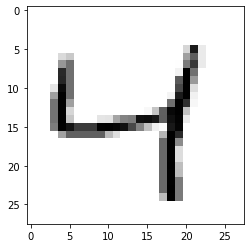

In [33]:
plt.imshow(x_train_img[2], cmap='Greys')

In [34]:
x_train = np.asarray(x_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.int32)
x_test =  np.asarray(x_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.int32)

# Primitive functions


### Sin

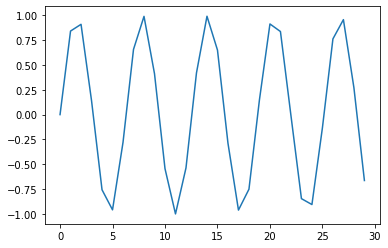

In [12]:
plt.plot(np.sin(np.arange(0,30)))

### Cosin

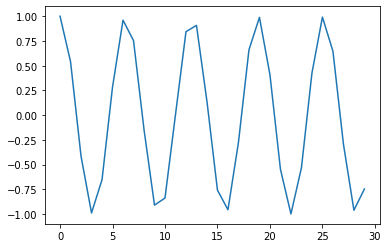

In [22]:
plt.plot(np.cos(np.arange(0,30)))

#### sqrt

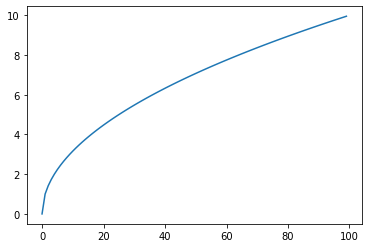

In [20]:
plt.plot(np.sqrt(np.arange(0,100)))

### log

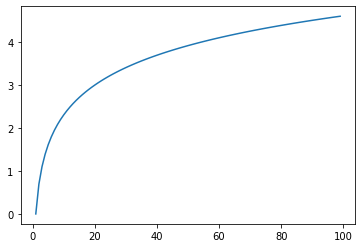

In [23]:
plt.plot(np.log(np.arange(0,100)))

### 4 number average

In [44]:
5%4

1

In [46]:
for i in range(4, 5, 4):
    print(i)

4


In [63]:
class Functions():
    def four_number_average(self, input_data):
       return  __x_number_average(input_data, 4)

    def __x_number_average(self, input_data, stride):
        len_ = len(input_data)
        new_data = []
        previous_row = 0
        for i in range(stride, len_, stride):
            new_data.append(np.mean(input_data[previous_row: i]))
            previous_row = i
            if i > (len_ - stride) & (len_ % stride != 0):
                new_data.append(np.mean(input_data[i:]))
        return new_data

        
        

    

In [64]:
assert f.four_number_average([10,10,20,20,10]) == [15,10]

4
4 5 4


# Define a non NN model

In [28]:
PRIMITIVE_FUCNTIONS_LOG = ['sqrt', 'log', 'cos', 'sin',]

In [36]:
x_train[0,...]

(784,)

# Define a NN model

In [ ]:
# activations
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)